In [26]:
import pandas as pd
import os

# Directory path for the cleaned data
PREP_FOLDER = 'cleaned'

# Load the cleaned CSV files
users_df = pd.read_csv(os.path.join(PREP_FOLDER, 'users.csv'))  # User data
certificates_df = pd.read_csv(os.path.join(PREP_FOLDER, 'certificates_cleaned.csv'))  # Certificates data
course_assignments_df = pd.read_csv(os.path.join(PREP_FOLDER, 'course_assignments_cleaned.csv'))  # Course Assignments data
performance_summaries_df = pd.read_csv(os.path.join(PREP_FOLDER, 'performance_summaries_cleaned.csv'))  # Performance Summaries data
learning_paths_df = pd.read_csv(os.path.join(PREP_FOLDER, 'learning_paths.csv'))  # Learning Paths data

# Step 1: Join Certificates with Course Assignments to track assignment_id
certificates_course_df = pd.merge(
    certificates_df,
    course_assignments_df,
    left_on='assignment_id',  # Column in certificates_df
    right_on='id',  # Column in course_assignments_df
    how='inner',
    suffixes=('_cert', '_assign')  # Rename columns to avoid conflicts
)

# Print the columns of the merged certificates_course_df
print("Certificates Course DataFrame columns after merge:", certificates_course_df.columns.tolist())

# Step 2: Merge the performance summaries with learning paths
user_performance_df = pd.merge(
    performance_summaries_df,
    learning_paths_df,
    left_on='learning_path_id',  # Column in performance_summaries_df
    right_on='id',  # Column in learning_paths_df
    how='inner',
    suffixes=('', '_lp')  # Add suffix to distinguish learning path columns
)

# Print the columns of the user_performance_df
print("User Performance DataFrame columns after merge:", user_performance_df.columns.tolist())

# Step 3: Merge the user performance with certificates
# Check the columns available in certificates_course_df
print("Certificates Course DataFrame before merging:", certificates_course_df.head())

final_df = pd.merge(
    user_performance_df,
    certificates_course_df[['assignment_id', 'user_id_cert']],  # Use 'user_id_cert' if that exists
    left_on='user_id',  # Use user_id from user_performance_df
    right_on='user_id_cert',  # Use user_id_cert from certificates_course_df
    how='left'  # Use left join to keep all user performances
)

# Step 4: Count unique certificates for each user and learning path
total_certifications_df = final_df.groupby(['user_id', 'learning_path_id']).agg(
    total_certifications=('assignment_id', 'nunique'),  # Count unique assignment IDs for certifications
    average_performance=('average_rating', 'mean')  # Average performance rating
).reset_index()

# Optionally join with users to get user details
total_certifications_df = total_certifications_df.merge(users_df[['id', 'name']], left_on='user_id', right_on='id', how='left')

# Rename columns for clarity
total_certifications_df = total_certifications_df.rename(columns={'learning_path_id': 'Learning Path ID', 
                                                                'total_certifications': 'Total Certifications', 
                                                                'average_performance': 'Average Performance',
                                                                'name': 'User Name'})

# Display the final DataFrame with total certifications
print(total_certifications_df)

# Save the final DataFrame to a CSV file if needed
total_certifications_df.to_csv(os.path.join(PREP_FOLDER, 'user_learning_path_certifications.csv'), index=False)


Certificates Course DataFrame columns after merge: ['id_cert', 'is_certified', 'user_id_cert', 'assignment_id', 'id_assign', 'user_id_assign', 'course_id', 'progress', 'assignment_date', 'quiz_score', 'engagement_score', 'assignment_grade']
User Performance DataFrame columns after merge: ['id', 'user_id', 'average_rating', 'learning_path_id', 'id_lp', 'title', 'description']
Certificates Course DataFrame before merging:    id_cert  is_certified  user_id_cert  assignment_id  id_assign  \
0        1         False             1              1          1   
1        2          True             1              2          2   
2        3          True             1              3          3   
3        4          True             1              4          4   
4        5          True             1              5          5   

   user_id_assign  course_id  progress             assignment_date  \
0               1         12       100  2024-10-14 04:02:39.872000   
1               1        16

In [53]:
import pandas as pd
import os

# Define directories for input and output
PREP_FOLDER = 'cleaned'
JOINED_FOLDER = 'joined'

# Ensure the joined folder exists
os.makedirs(JOINED_FOLDER, exist_ok=True)

# Load the cleaned CSV files
certificates_df = pd.read_csv(os.path.join(PREP_FOLDER, 'certificates_cleaned.csv'))  # Certificates data
course_assignments_df = pd.read_csv(os.path.join(PREP_FOLDER, 'course_assignments_cleaned.csv'))  # Course Assignments data
course_learning_paths_df = pd.read_csv(os.path.join(PREP_FOLDER, 'course_learning_paths.csv'))  # Course Learning Paths data

# Step 1: Merge Certificates with Course Assignments
certificates_course_df = pd.merge(
    certificates_df,
    course_assignments_df,
    left_on='assignment_id',  # Column in certificates_df
    right_on='id',  # Column in course_assignments_df
    how='inner',
    suffixes=('_cert', '_assign')  # Rename columns to avoid conflicts
)

# Debug: Check the merged Certificates Course DataFrame
print("Merged Certificates Course DataFrame:")
print(certificates_course_df.head())

# Step 2: Merge the result with Course Learning Paths to get Learning Path IDs
final_df = pd.merge(
    certificates_course_df,
    course_learning_paths_df,
    left_on='course_id',  # Column in the certificates_course_df
    right_on='course_id',  # Column in course_learning_paths_df
    how='inner'
)

# Debug: Check the final merged DataFrame
print("Final Merged DataFrame:")
print(final_df.head())

# Step 3: Count unique certifications (is_certified True) and total courses assigned for each user and learning path
# Count total courses assigned regardless of certification
total_courses_assigned_df = final_df.groupby(
    ['user_id_cert', 'learning_path_id']
).agg(
    total_courses_assigned=('id_assign', 'count')  # Count all assignments for each user and learning path
).reset_index()

# Count unique certifications only where is_certified is True
certified_count_df = final_df[final_df['is_certified'] == True].groupby(
    ['user_id_cert', 'learning_path_id']
).agg(
    total_certifications=('assignment_id', 'nunique')  # Count unique assignment IDs for certifications
).reset_index()

# Merge the two DataFrames to combine counts
certificate_count_df = pd.merge(
    total_courses_assigned_df,
    certified_count_df,
    on=['user_id_cert', 'learning_path_id'],  # Merge on user_id and learning_path
    how='left'
)

# Fill NaN values for total_certifications with 0 (in case there are no certifications)
certificate_count_df['total_certifications'].fillna(0, inplace=True)

# Convert total_certifications to integer
certificate_count_df['total_certifications'] = certificate_count_df['total_certifications'].astype(int)

# Rename columns for clarity
certificate_count_df.rename(columns={'user_id_cert': 'user_id'}, inplace=True)

# Debug: Check the counts DataFrame
print("Total Certifications and Courses Assigned DataFrame:")
print(certificate_count_df)

# Step 4: Save the result to a CSV file
output_file_path = os.path.join(JOINED_FOLDER, 'user_learning_path_certificates_count.csv')
certificate_count_df.to_csv(output_file_path, index=False)

print(f'User Learning Path Certifications Count saved to: {output_file_path}')


Merged Certificates Course DataFrame:
   id_cert  is_certified  user_id_cert  assignment_id  id_assign  \
0        1          True             1              1          1   
1        2         False             1              2          2   
2        3         False             1              3          3   
3        4          True             1              4          4   
4        5          True             1              5          5   

   user_id_assign  course_id  progress             assignment_date  \
0               1         12       100  2024-10-14 06:33:13.744000   
1               1        166       100  2024-10-14 06:33:13.744000   
2               1         13       100  2024-10-14 06:33:13.745000   
3               1         17       100  2024-10-14 06:33:13.745000   
4               1         20       100  2024-10-14 06:33:13.745000   

   quiz_score  engagement_score  assignment_grade  
0        74.0                67                79  
1        72.0               

C:\Users\VijayR\AppData\Local\Temp\ipykernel_20004\949562639.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  certificate_count_df['total_certifications'].fillna(0, inplace=True)


In [54]:
import pandas as pd
import os

# Define directories for input and output
PREP_FOLDER = 'cleaned'
JOINED_FOLDER = 'joined'

# Ensure the joined folder exists
os.makedirs(JOINED_FOLDER, exist_ok=True)

# Load the cleaned CSV files
users_df = pd.read_csv(os.path.join(PREP_FOLDER, 'users.csv'))  # User data
performance_summaries_df = pd.read_csv(os.path.join(PREP_FOLDER, 'performance_summaries_cleaned.csv'))  # Performance summaries data

# Check the columns of users_df
print("Columns in Users DataFrame:")
print(users_df.columns.tolist())

# Check the columns of performance_summaries_df
print("Columns in Performance Summaries DataFrame:")
print(performance_summaries_df.columns.tolist())

# Step 1: Merge Users with Performance Summaries
final_performance_df = pd.merge(
    users_df,
    performance_summaries_df,
    left_on='id',  # User ID in users_df
    right_on='user_id',  # User ID in performance_summaries_df
    how='inner',
    suffixes=('_user', '_summary')  # Rename columns to avoid conflicts
)

# Debug: Check the final merged DataFrame
print("Final Merged Performance DataFrame:")
print(final_performance_df.head())

# Step 2: Save the result to a CSV file
output_file_path = os.path.join(JOINED_FOLDER, 'user_performance_summaries.csv')
final_performance_df.to_csv(output_file_path, index=False)

print(f'User Performance Summaries saved to: {output_file_path}')


Columns in Users DataFrame:
['id', 'name', 'designation', 'role']
Columns in Performance Summaries DataFrame:
['id', 'user_id', 'average_rating', 'learning_path_id']
Final Merged Performance DataFrame:
   id_user          name    designation      role  id_summary  user_id  \
0        1  Abigail Gray  Data Engineer  employee         1.0      1.0   
1        1  Abigail Gray  Data Engineer  employee         2.0      1.0   
2        1  Abigail Gray  Data Engineer  employee         3.0      1.0   
3        1  Abigail Gray  Data Engineer  employee         4.0      1.0   
4        1  Abigail Gray  Data Engineer  employee         5.0      1.0   

   average_rating  learning_path_id  
0           78.75               2.0  
1           70.00              17.0  
2           75.50              16.0  
3           81.00               6.0  
4           85.00              19.0  
User Performance Summaries saved to: joined\user_performance_summaries.csv


JOINING ALL THE TABLE FROM EXISTING JOINED TABLE

In [55]:
import pandas as pd
import os

# Define directories for input and output
JOINED_FOLDER = 'joined'

# Ensure the joined folder exists
os.makedirs(JOINED_FOLDER, exist_ok=True)

# Load the cleaned CSV files
certification_counts_df = pd.read_csv(os.path.join(JOINED_FOLDER, 'user_learning_path_certificates_count.csv'))
performance_summaries_df = pd.read_csv(os.path.join(JOINED_FOLDER, 'user_performance_summaries.csv'))

# Step 1: Merge the DataFrames on user_id and learning_path_id
merged_df = pd.merge(
    certification_counts_df,
    performance_summaries_df,
    on=['user_id', 'learning_path_id'],  # Columns to merge on
    how='inner'  # Use inner join to keep only matching records
)

# Debug: Check the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())

# Step 2: Select and rename the required columns for clarity
final_output_df = merged_df[['user_id', 'learning_path_id', 'total_certifications', 'total_courses_assigned', 'average_rating']]

# Step 3: Ensure total_certifications are integers
final_output_df['total_certifications'] = final_output_df['total_certifications'].astype(int)

# Step 4: Save the result to a CSV file
output_file_path = os.path.join(JOINED_FOLDER, 'final_user_learning_path_data.csv')
final_output_df.to_csv(output_file_path, index=False)

print(f'Final User Learning Path Data saved to: {output_file_path}')


Merged DataFrame:
   user_id  learning_path_id  total_courses_assigned  total_certifications  \
0        1                 2                       4                     3   
1        1                 6                       1                     1   
2        1                14                       2                     1   
3        1                16                       2                     1   
4        1                17                       1                     0   

   id_user          name    designation      role  id_summary  average_rating  
0        1  Abigail Gray  Data Engineer  employee         1.0           78.75  
1        1  Abigail Gray  Data Engineer  employee         4.0           81.00  
2        1  Abigail Gray  Data Engineer  employee         6.0           77.00  
3        1  Abigail Gray  Data Engineer  employee         3.0           75.50  
4        1  Abigail Gray  Data Engineer  employee         2.0           70.00  
Final User Learning Path Data sav

C:\Users\VijayR\AppData\Local\Temp\ipykernel_20004\3167822486.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_output_df['total_certifications'] = final_output_df['total_certifications'].astype(int)


USING MODEL AND HEATMAP

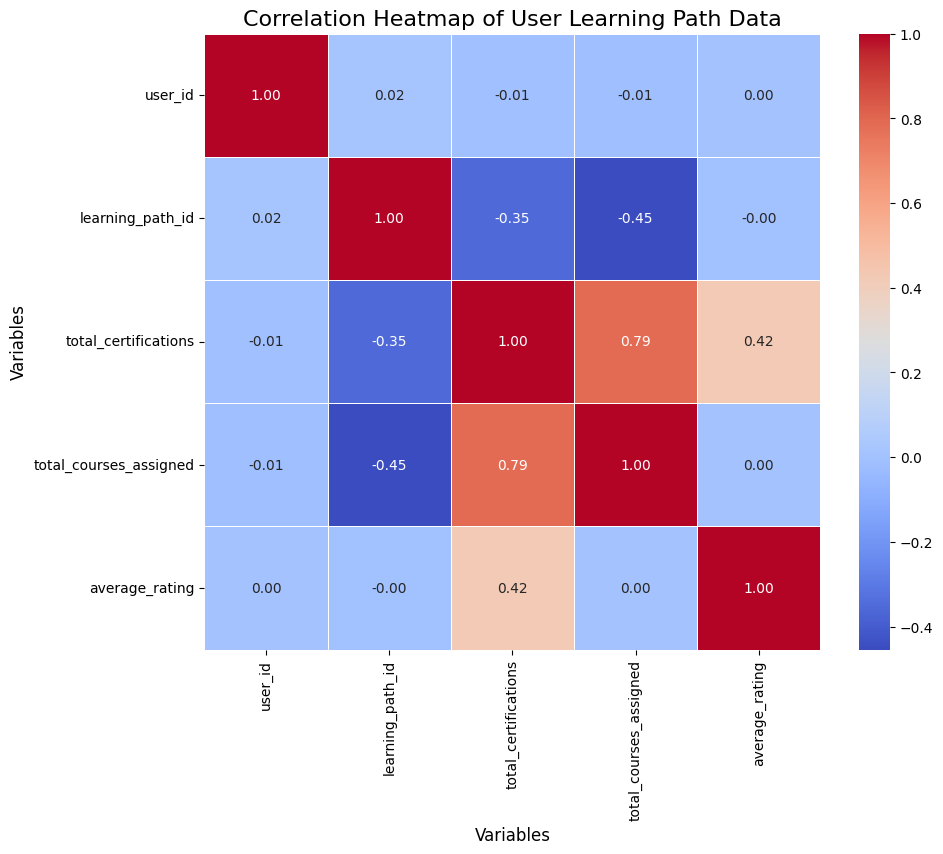

Correlation Matrix:
                         user_id  learning_path_id  total_certifications  \
user_id                 1.000000          0.016067             -0.009648   
learning_path_id        0.016067          1.000000             -0.353886   
total_certifications   -0.009648         -0.353886              1.000000   
total_courses_assigned -0.011955         -0.454405              0.785890   
average_rating          0.004108         -0.000147              0.421312   

                        total_courses_assigned  average_rating  
user_id                              -0.011955        0.004108  
learning_path_id                     -0.454405       -0.000147  
total_certifications                  0.785890        0.421312  
total_courses_assigned                1.000000        0.001007  
average_rating                        0.001007        1.000000  

Confusion Matrix:
[[549 192]
 [176 685]]

Classification Report:
              precision    recall  f1-score   support

           0

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the path for the input CSV file
JOINED_FOLDER = 'joined'
input_file_path = os.path.join(JOINED_FOLDER, 'final_user_learning_path_data.csv')

# Load the final user learning path data
data_df = pd.read_csv(input_file_path)

# Step 1: Create a correlation matrix
correlation_matrix = data_df.corr()

# Step 2: Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Step 3: Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

# Step 4: Add titles and labels
plt.title('Correlation Heatmap of User Learning Path Data', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Step 5: Show the heatmap
plt.show()
print("Correlation Matrix:")
print(correlation_matrix)

# Step 6: Prepare the data for classification
# Define the feature columns and target variable
# You may choose 'average_rating' or any other variable based on your analysis
X = data_df[['user_id', 'learning_path_id', 'total_certifications', 'total_courses_assigned']]
y = (data_df['average_rating'] >= 80).astype(int)  # Binary classification target: 1 if average_rating >= 80, else 0

# Step 7: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 9: Make predictions
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os

# Define the path for the input CSV files
JOINED_FOLDER = 'joined'
performance_summaries_path = os.path.join(JOINED_FOLDER, 'user_performance_summaries.csv')
learning_paths_path = os.path.join(JOINED_FOLDER, 'final_user_learning_path_data.csv')

# Load the data
performance_summaries_df = pd.read_csv(performance_summaries_path)
learning_paths_df = pd.read_csv(learning_paths_path)

# Print the column names of both DataFrames for debugging
print("Performance Summaries Columns:", performance_summaries_df.columns.tolist())
print("Learning Paths Columns:", learning_paths_df.columns.tolist())

# Merge the dataframes on user_id and learning_path_id
merged_df = pd.merge(learning_paths_df, performance_summaries_df, on=['user_id', 'learning_path_id'])

# Print the merged DataFrame columns to verify
print("Merged DataFrame Columns:", merged_df.columns.tolist())

# Selecting features and target variable
try:
    feature_columns = ['total_certifications', 'total_courses_assigned', 'average_rating_x']  # Using average_rating from learning_paths_df
    missing_columns = [col for col in feature_columns if col not in merged_df.columns]
    
    if missing_columns:
        raise KeyError(f"The following columns are missing from the merged DataFrame: {missing_columns}")

    X = merged_df[feature_columns]
    y = merged_df['learning_path_id']  # Assuming this is the target variable for learning path recommendation

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Recommend learning paths for all users
    suggested_paths = []

    for user_id in merged_df['user_id'].unique():
        user_data = merged_df[merged_df['user_id'] == user_id]
        
        if user_data.empty:
            print(f"No data available for user_id: {user_id}")
            continue
        
        # Filter courses that meet the average rating threshold
        eligible_courses = user_data[user_data['average_rating_x'] >= 75]  # Adjust threshold as needed

        if eligible_courses.empty:
            print(f"No learning paths found for user_id {user_id} with an average rating above 75.")
        else:
            # Get the learning path with the highest average rating
            best_course = eligible_courses.loc[eligible_courses['average_rating_x'].idxmax()]
            suggested_paths.append({
                'user_id': user_id,
                'learning_path_id': best_course['learning_path_id']
            })

    # Create a DataFrame from the suggested paths
    suggested_df = pd.DataFrame(suggested_paths)

    # Save the suggested learning paths to a CSV file
    suggested_csv_path = os.path.join(JOINED_FOLDER, 'suggested_learning_paths.csv')
    suggested_df.to_csv(suggested_csv_path, index=False)

    print(f"Suggested learning paths have been saved to: {suggested_csv_path}")

except KeyError as e:
    print(f"KeyError: {e}")


Performance Summaries Columns: ['id_user', 'name', 'designation', 'role', 'id_summary', 'user_id', 'average_rating', 'learning_path_id']
Learning Paths Columns: ['user_id', 'learning_path_id', 'total_certifications', 'total_courses_assigned', 'average_rating']
Merged DataFrame Columns: ['user_id', 'learning_path_id', 'total_certifications', 'total_courses_assigned', 'average_rating_x', 'id_user', 'name', 'designation', 'role', 'id_summary', 'average_rating_y']
Classification Report:
              precision    recall  f1-score   support

           1       0.04      0.02      0.02        66
           2       0.92      0.96      0.94       193
           3       0.00      0.00      0.00        63
           4       0.00      0.00      0.00        61
           5       0.05      0.06      0.05        50
           6       0.00      0.00      0.00        73
           7       0.33      0.02      0.05        82
           8       0.00      0.00      0.00        71
           9       0.00  

c:\Users\VijayR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VijayR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VijayR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Suggested learning paths have been saved to: joined\suggested_learning_paths.csv
